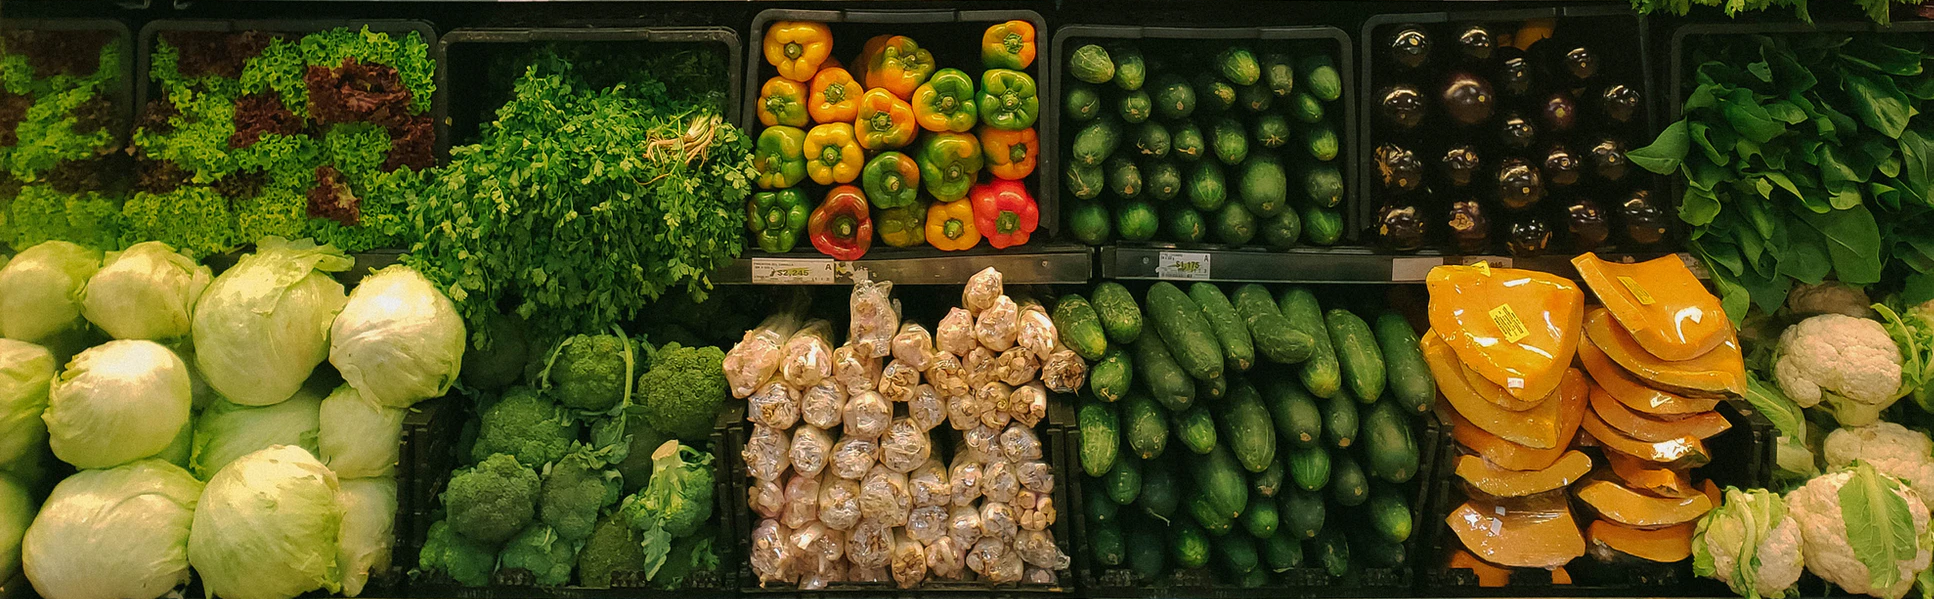

## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

In [1]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [2]:
#od.download('https://www.kaggle.com/c/rossmann-store-sales/data')

In [3]:
#!pip install opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

In [4]:
os.listdir('rossmann-store-sales')

['test.csv', 'train.csv', 'sample_submission.csv', 'store.csv', 'untitled.txt']

### Files
* train.csv - historical data including Sales


* test.csv - historical data excluding Sales


* sample_submission.csv - a sample submission file in the correct format



* store.csv - supplemental information about the stores


In [5]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory = False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')

In [6]:
ross_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id** - an Id that represents a (Store, Date) duple within the test set


* **Store** - a unique Id for each store


* **Sales** - the turnover for any given day (this is what you are predicting)


* **Customers** - the number of customers on a given day


* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open


* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools


* **StoreType** - differentiates between 4 different store models: a, b, c, d


* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended


* **CompetitionDistance** - distance in meters to the nearest competitor store


* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened


* **Promo** - indicates whether a store is running a promo on that day


* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating


* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2


* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [9]:
print('Shape Training Dataset:', ross_df.shape)

Shape Training Dataset: (1017209, 9)


Let's merge the information from `store_df` into `train_df` and `test_df`

In [10]:
merged_train_df = ross_df.merge(store_df, on = 'Store', how = 'left')
merged_test_df = test_df.merge(store_df, on = 'Store', how = 'left')

In [11]:
print(merged_train_df.shape)
print(merged_test_df.shape)

(1017209, 18)
(41088, 17)


In [12]:
merged_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data Exploration & Visualization

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_style('whitegrid')

In [14]:
data = merged_train_df.copy()

In [15]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [16]:
def reduce_size(df):
    
#     df.columns = df.columns.str.replace(' ', '_').str.lower()
        
    
    columns = df.columns.to_list()
    for col in columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float64')
        elif df[col].dtype == 'object':
            df[col] = df[col].astype('category') 
        
    return df

In [17]:
data = reduce_size(merged_train_df)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Store                      1017209 non-null  int32   
 1   DayOfWeek                  1017209 non-null  int32   
 2   Date                       1017209 non-null  category
 3   Sales                      1017209 non-null  int32   
 4   Customers                  1017209 non-null  int32   
 5   Open                       1017209 non-null  int32   
 6   Promo                      1017209 non-null  int32   
 7   StateHoliday               1017209 non-null  category
 8   SchoolHoliday              1017209 non-null  int32   
 9   StoreType                  1017209 non-null  category
 10  Assortment                 1017209 non-null  category
 11  CompetitionDistance        1014567 non-null  float64 
 12  CompetitionOpenSinceMonth  693861 non-null   float64 
 1

In [18]:
merged_train_df['Sales'].agg(['min', 'max', 'mean', 'median', 'std'])

min           0.000000
max       41551.000000
mean       5773.818972
median     5744.000000
std        3849.926175
Name: Sales, dtype: float64

In [19]:
data['Sales'].agg(['min', 'max', 'mean', 'median', 'std'])

min           0.000000
max       41551.000000
mean       5773.818972
median     5744.000000
std        3849.926175
Name: Sales, dtype: float64

In [20]:
round(data['Customers'].describe())

count    1017209.0
mean         633.0
std          464.0
min            0.0
25%          405.0
50%          609.0
75%          837.0
max         7388.0
Name: Customers, dtype: float64

In [21]:
data['Customers'].max()

7388

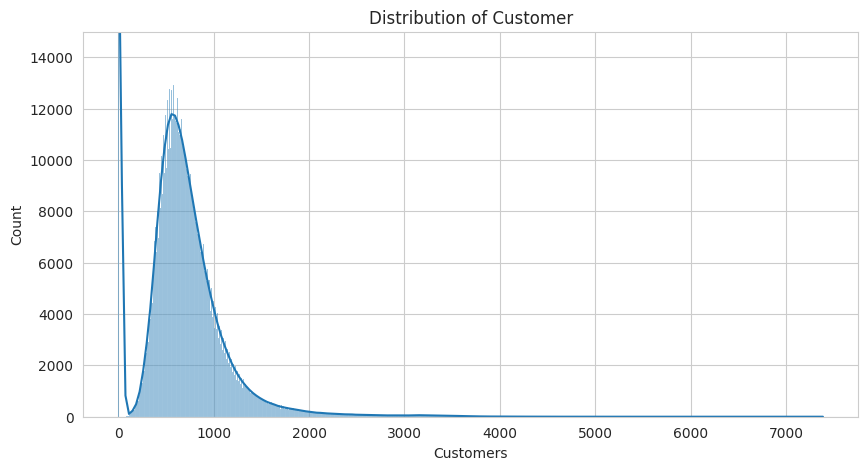

In [22]:
plt.subplots(figsize = (10,5))
sns.histplot(data.Customers, kde = True)
plt.title('Distribution of Customer')
# plt.axvline(data.Customers.mean(), ls = '-')
plt.ylim(0, 15000);

In [23]:
data.Store.nunique()

1115

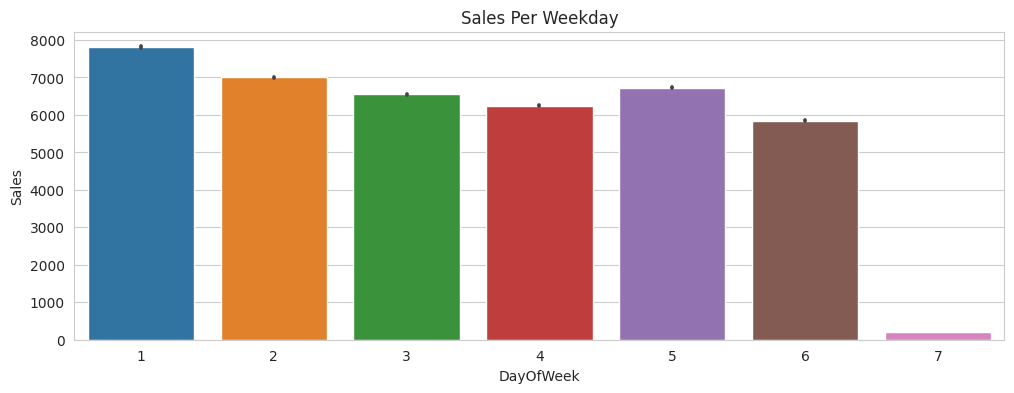

In [24]:
plt.figure(figsize = (12,4))
sns.barplot(x = 'DayOfWeek', y = 'Sales', data = data)
plt.title('Sales Per Weekday');

Generally Speaking, On Sunday(7th) usually poeple are free and it's more likely to rise volumns of sales but Since we are talking about drug stores, some of them might be closed on sunday. Let's find out

In [25]:
df_day7 = data[data['DayOfWeek'] == 7][['Sales', 'Open']]
df_day7.Open.nunique()

2

In [26]:
df_day7.Open.value_counts()

0    141137
1      3593
Name: Open, dtype: int64

<AxesSubplot:>

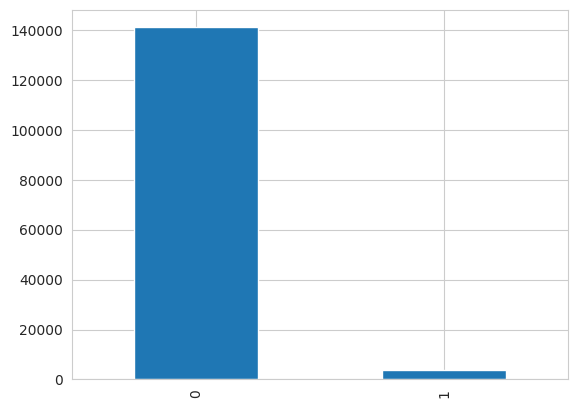

In [27]:
df_day7.Open.value_counts().plot(kind = 'bar')

We were right, About most of the stores being closed on sunday accross europe. 

In [28]:
df_day7.Open.value_counts()

0    141137
1      3593
Name: Open, dtype: int64

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Sales'>

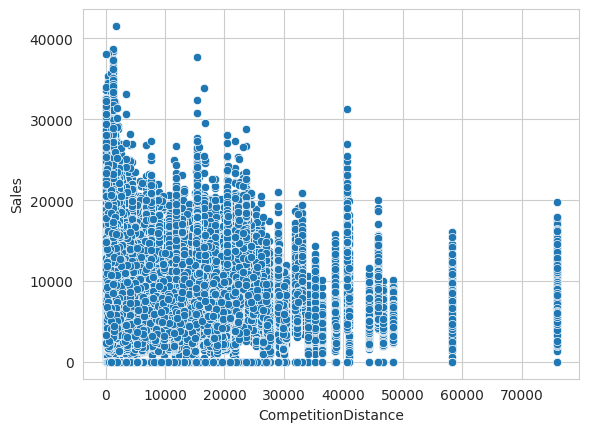

In [29]:
sns.scatterplot(x = 'CompetitionDistance', y = 'Sales', data = data)

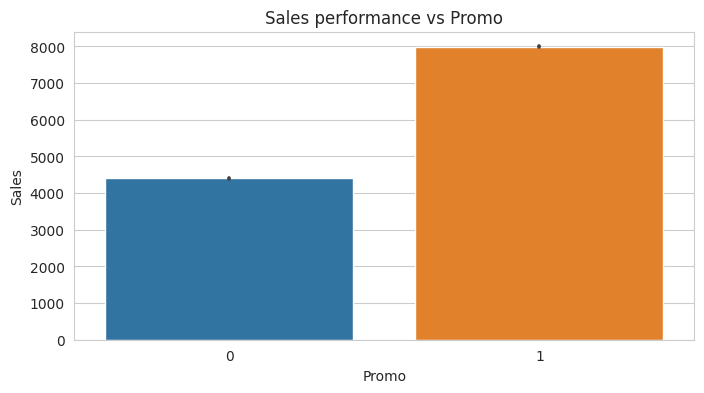

In [30]:
plt.figure(figsize = (8,4))
sns.barplot(x = 'Promo', y = 'Sales', data = data)
plt.title('Sales performance vs Promo');

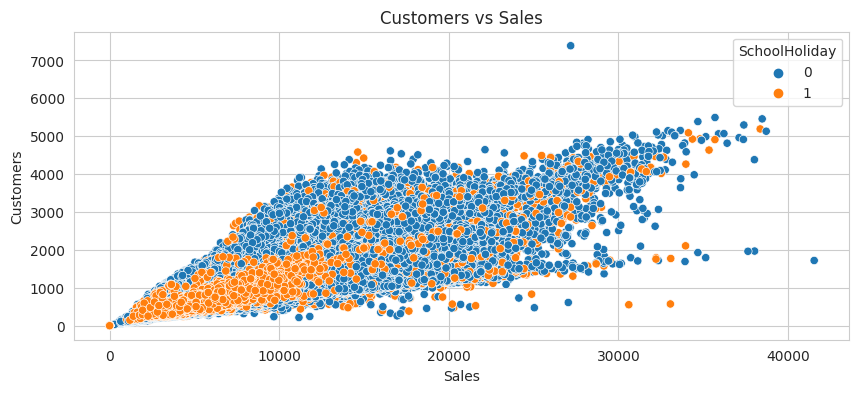

In [31]:
plt.figure(figsize = (10,4))
sns.scatterplot(
    x = 'Sales',
    y = 'Customers',
    hue = 'SchoolHoliday',
    data = data
)
plt.title('Customers vs Sales');

In [32]:
data['Customers'].corr(data['Sales'])

0.8947107733017032

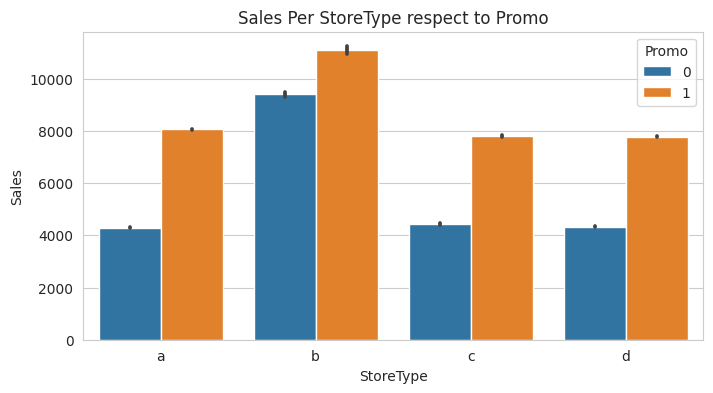

In [33]:
plt.figure(figsize = (8,4))
sns.barplot(
    x = 'StoreType',
    y = 'Sales', 
    hue = 'Promo',
    data = data
)
plt.title('Sales Per StoreType respect to Promo');

By Looking at above chart we can say that the most sales was made by StoreType `'b'`. Let's seek reason behind it!
* First, let's see how Promotion affect the sales? 

<AxesSubplot:xlabel='Promo', ylabel='Sales'>

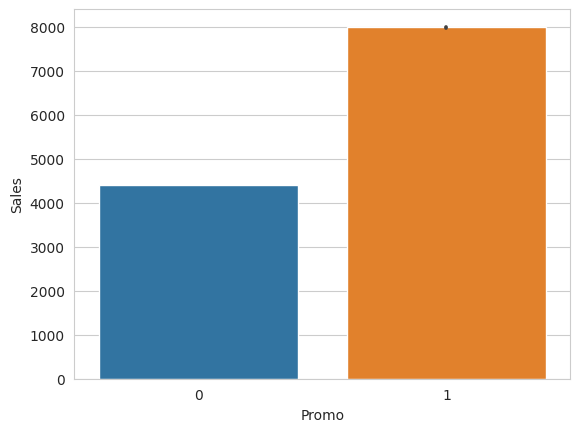

In [34]:
sns.barplot(x = 'Promo', y = 'Sales', data = data);

By looking at above chart we can see that, promotion actually impact the sales. Let's see whether `StoreType 'b'`, has lunch most pomotion?

In [35]:
promo_df = (
    data['Promo']
    .groupby(data['StoreType'])
    .value_counts()
    .rename('frequency')
    .sort_values(ascending = False)
    .reset_index()
)
promo_df

,StoreType,Promo,frequency
0,a,0,341123
1,a,1,210504
2,d,0,193626
3,d,1,119286
4,c,0,84596
5,c,1,52244
6,b,0,9784
7,b,1,6046


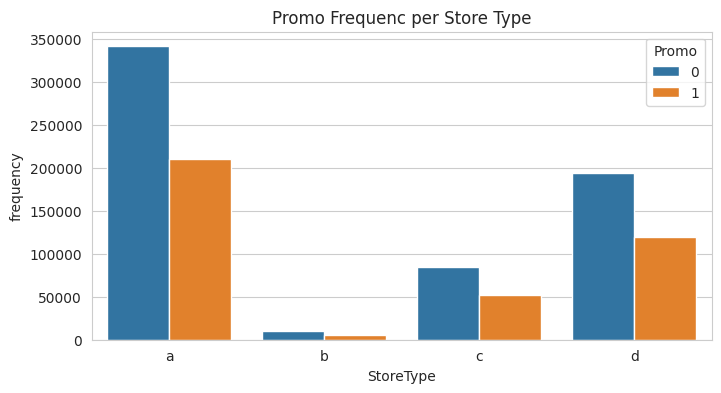

In [36]:
plt.figure(figsize = (8,4))
sns.barplot(
    x = 'StoreType',
    y = 'frequency', 
    hue = 'Promo',
    data = promo_df
)
plt.title('Promo Frequenc per Store Type');

ohh!, Looking at above graph we can say that, the least promotion were luched by `StoreType 'b'`. We were wrong!, now let's found out whether `StoreType 'b'` is open on `sunday`?

In [37]:
day_df = data[(data['DayOfWeek'] == 7) & (data['Open'] == 1)]
day_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
5659,85,7,2015-07-26,11421,1606,1,0,0,0,b,a,1870.0,10.0,2011.0,0,NaN,NaN,NaN
5696,122,7,2015-07-26,5773,707,1,0,0,0,a,c,58260.0,4.0,2013.0,0,NaN,NaN,NaN
5783,209,7,2015-07-26,3742,354,1,0,0,0,a,c,11680.0,9.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
5833,259,7,2015-07-26,15998,2857,1,0,0,0,b,b,210.0,NaN,NaN,0,NaN,NaN,NaN
5836,262,7,2015-07-26,32547,4783,1,0,0,0,b,a,1180.0,5.0,2013.0,0,NaN,NaN,NaN


In [38]:
day_df['StoreType'].value_counts()

b    2216
a    1100
d     277
c       0
Name: StoreType, dtype: int64

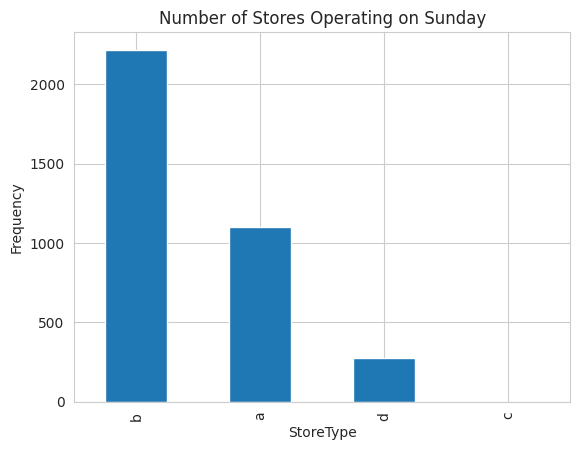

In [39]:
day_df['StoreType'].value_counts().plot(
    kind = 'bar',
    xlabel = 'StoreType',
    ylabel = 'Frequency',
    title = 'Number of Stores Operating on Sunday' 
);

So, finally we can say that the main reason `StoreType 'b'` is making most sales is because it is usually open on Sunday.

In [40]:
# corr = data.select_dtypes('number').drop(columns = ['Store', ']).corr()
# corr.style.background_gradient(axis=None)

In [42]:
pip install parquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.4/627.4 kB 6.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
  Created wheel for thriftpy2: filename=thriftpy2-0.4.15-cp37-cp37m-linux_x86_64.whl size=984321 sha256=2d0155da1c92cff20600a2956dc6c8c310a50a1c796611e85d4d4abbd5d7ac92
  Stored in directory: /home/jovyan/.cache/pip/wheels/8a/5d/d3/dca2bdb46aa3dfa433d6484215eda940d9984dad334ac5c4be
Successfully built thriftpy2
Note: you may need to restart the kernel to use updated packages.


In [62]:
def get_date(data):
    data['Year'] = pd.to_datetime(data['Date']).dt.year
    data['Month'] = pd.to_datetime(data['Date']).dt.month
    data['Quarter'] = pd.to_datetime(data['Date']).dt.quarter
    data['Day'] = pd.to_datetime(data['Date']).dt.day
    return data

In [63]:
data = get_date(data).copy()
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,Quarter,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2015,3,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,2015,3,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,2015,3,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,7,2015,3,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,7,2015,3,31


In [65]:
data.CompetitionOpenSinceYear

0          2008.0
1          2007.0
2          2006.0
3          2009.0
4          2015.0
            ...  
1017204    2014.0
1017205    2006.0
1017206       NaN
1017207       NaN
1017208       NaN
Name: CompetitionOpenSinceYear, Length: 1017209, dtype: float64

In [89]:
def comp_months(data):
    data['CompetitionOpen'] = 12* (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0) 
    return data

In [90]:
data = comp_months(data).copy()

In [91]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,Quarter,Day,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2015,3,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,2015,3,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,2015,3,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,7,2015,3,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,7,2015,3,31,3.0


In [92]:
data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Year,Quarter,Day,CompetitionOpen
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,5.846762e+00,2.013832e+03,2.294252e+00,1.570279e+01,4.203993e+01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,3.326097e+00,7.773960e-01,1.081850e+00,8.787638e+00,6.534447e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,1.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,3.000000e+00,2.013000e+03,1.000000e+00,8.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,6.000000e+00,2.014000e+03,2.000000e+00,1.600000e+01,1.600000e+01
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,8.000000e+00,2.014000e+03,3.000000e+00,2.300000e+01,7.300000e+01
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000,1.200000e+01,2.015000e+03,4.000000e+00,3.100000e+01,1.386000e+03


In [96]:
def outliers(df):
    loop = 0
    cols = ['Sales', 'Customers', 'CompetitionOpen']
    for col in cols:
        q1, q9 = df[col].quantile([0.10, 0.90])
        mask = df[col].between(q1,q9)
        df_mask = df[mask]
        df[col] = df_mask[col]
        loop += 1
        if loop == len(cols):
            break
    #print(loop)
    return df

In [97]:
data = outliers(data).copy()

In [98]:
data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Year,Quarter,Day,CompetitionOpen
count,814341.000000,1.017209e+06,824012.000000,824943.000000,1.017209e+06,1.017209e+06,1.017209e+06,816270.000000,585627.000000,591691.000000,1.017209e+06,434856.000000,500126.000000,953659.000000,1.017209e+06,1.017209e+06,837125.000000,825842.000000
mean,558.558245,3.998341e+00,4465.901648,477.287974,8.301067e-01,3.815145e-01,1.786467e-01,3775.780489,7.220789,2009.511924,5.005638e-01,22.766226,2011.694001,5.436722,2.013832e+03,2.294252e+00,16.000000,20.413856
std,257.694947,1.997391e+00,2701.071206,286.696882,3.755392e-01,4.857586e-01,3.830564e-01,3758.524815,2.716282,3.230764,4.999999e-01,12.110792,1.618914,3.018099,7.773960e-01,1.081850e+00,7.211107,27.469965
min,112.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,240.000000,3.000000,2003.000000,0.000000e+00,5.000000,2009.000000,1.000000,2.013000e+03,1.000000e+00,4.000000,0.000000
25%,335.000000,2.000000e+00,2995.000000,331.000000,1.000000e+00,0.000000e+00,0.000000e+00,1000.000000,4.000000,2007.000000,0.000000e+00,13.000000,2011.000000,3.000000,2.013000e+03,1.000000e+00,10.000000,0.000000
50%,558.000000,4.000000e+00,5064.000000,540.000000,1.000000e+00,0.000000e+00,0.000000e+00,2320.000000,7.000000,2010.000000,1.000000e+00,18.000000,2012.000000,5.000000,2.014000e+03,2.000000e+00,16.000000,0.000000
75%,782.000000,6.000000e+00,6546.000000,695.000000,1.000000e+00,1.000000e+00,0.000000e+00,5290.000000,9.000000,2012.000000,1.000000e+00,36.000000,2013.000000,8.000000,2.014000e+03,3.000000e+00,22.000000,39.000000
max,1004.000000,7.000000e+00,8597.000000,920.000000,1.000000e+00,1.000000e+00,1.000000e+00,15710.000000,11.000000,2014.000000,1.000000e+00,40.000000,2014.000000,11.000000,2.015000e+03,4.000000e+00,28.000000,89.000000


In [1]:
import pandas as pd

In [ ]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory = False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')

In [6]:
def get_date(data):
    data['Year'] = pd.to_datetime(data['Date']).dt.year
    data['Month'] = pd.to_datetime(data['Date']).dt.month
    data['Quarter'] = pd.to_datetime(data['Date']).dt.quarter
    data['Day'] = pd.to_datetime(data['Date']).dt.day
    return data

In [7]:
def comp_months(data):
    data['CompetitionOpen'] = 12* (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0) 
    return data

In [36]:
def wrangle(filepath, store_data):
    
    #read store data
    store_df = pd.read_csv(store_data)
    
    #read train/test data
    train_df = pd.read_csv(filepath, low_memory = False)
    
    #merge dataset
    data = train_df.merge(store_df, on = 'Store', how = 'left').copy()
    
    # filter data that are open for training data 
    mask = data['Open'] == 1 
    data = data[mask].copy() #only for training data
    
    #drop features that has more than 40% 'nan' value
    drop_cols = []
    for col in  data.columns:
        if data[col].isna().sum()/len(data) >= 0.40:
            drop_cols.append(col)
        
    #split date
    data = get_date(data)
    
    #create CompetitionOpen columns (age of CompetitionOpen in months)
    data = comp_months(data)
    
    #replace int by month name in 'Month col'
    month_dict = {
    1:'Jan', 2:'Feb', 
    3:'Mar', 4:'Apr',
    5:'May', 6:'Jun',              
    7:'Jul', 8:'Aug',
    9:'Sept', 10:'Oct', 
    11:'Nov', 12:'Dec'
    }
    data['Month'] = data['Month'].replace(month_dict).copy()

    # #remove colinarity column
    # data = data.drop('Customers', axis = 1).copy()
    
    # drop columns 
    cols = ['Date', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']   
    drop_cols = (drop_cols + cols).copy()
    data = data.drop(drop_cols, axis = 1).copy()
    #outliers treatment 
    q1, q9 = data['CompetitionOpen'].quantile([0.10, 0.90])
    mask = data['CompetitionOpen'].between(q1,q9)
    data = data[mask]


    return data

In [37]:
data = wrangle('./rossmann-store-sales/train.csv', './rossmann-store-sales/store.csv')
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Quarter,Day,CompetitionOpen
0,1,5,5263,555,1,1,0,1,c,a,1270.0,0,2015,Jul,3,31,82.0
1,2,5,6064,625,1,1,0,1,a,a,570.0,1,2015,Jul,3,31,92.0
2,3,5,8314,821,1,1,0,1,a,a,14130.0,1,2015,Jul,3,31,103.0
3,4,5,13995,1498,1,1,0,1,c,c,620.0,0,2015,Jul,3,31,70.0
4,5,5,4822,559,1,1,0,1,a,a,29910.0,0,2015,Jul,3,31,3.0


In [32]:
lis

[('Date', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear')]

In [18]:
data.isna().sum()/len(data)

Store                  0.000000
DayOfWeek              0.000000
Sales                  0.000000
Open                   0.000000
Promo                  0.000000
StateHoliday           0.000000
SchoolHoliday          0.000000
StoreType              0.000000
Assortment             0.000000
CompetitionDistance    0.002872
Promo2                 0.000000
Promo2SinceWeek        0.506805
Promo2SinceYear        0.506805
PromoInterval          0.506805
Year                   0.000000
Month                  0.000000
Quarter                0.000000
Day                    0.000000
CompetitionOpen        0.000000
dtype: float64

In [20]:
for col in  data.columns:
    if data[col].isna().sum()/len(data) >= 0.40:
        print(col)

Promo2SinceWeek
Promo2SinceYear
PromoInterval


In [14]:
month_dict = {
    1:'Jan', 2:'Feb', 
    3:'Mar', 4:'Apr',
    5:'May', 6:'Jun',              
    7:'Jul', 8:'Aug',
    9:'Sept', 10:'Oct', 
    11:'Nov', 12:'Dec'
}
data['Month'].replace(month_dict)

0          Jul
1          Jul
2          Jul
3          Jul
4          Jul
          ... 
1016656    Jan
1016770    Jan
1016776    Jan
1016863    Jan
1017042    Jan
Name: Month, Length: 761127, dtype: object

In [13]:
data['Month']

0          7
1          7
2          7
3          7
4          7
          ..
1016656    1
1016770    1
1016776    1
1016863    1
1017042    1
Name: Month, Length: 761127, dtype: int64

In [28]:
data.CompetitionOpen.agg(['min', 'max', 'mean', 'median'])

min          0.000000
max       1386.000000
mean        41.953548
median      16.000000
Name: CompetitionOpen, dtype: float64

In [32]:
q1, q9 = data['CompetitionOpen'].quantile([0.10, 0.90])
mask = data['CompetitionOpen'].between(q1,q9)
data = data[mask]

In [33]:
data.CompetitionOpen.agg(['min', 'max', 'mean', 'median'])

min         0.000000
max       115.000000
mean       28.406567
median      8.000000
Name: CompetitionOpen, dtype: float64